In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

Part 1: Prepare the Data

In [4]:
file_path = Path("myopia.csv")
df = pd.read_csv(file_path)
df.head()


,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


In [5]:
df["MYOPIC"].nunique()
labels = df['MYOPIC']
labels.value_counts().nunique()

2

In [6]:
df.columns

Index(['AGE', 'SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR', 'READHR', 'COMPHR',
       'STUDYHR', 'TVHR', 'DIOPTERHR', 'MOMMY', 'DADMY', 'MYOPIC'],
      dtype='object')

In [7]:
df = df.drop('MYOPIC', axis = 1)
file_path = Path('cleaned_myopia.csv')
df.to_csv(file_path, index = False)

In [8]:
# Create a scaler to standardize the data
scaler = StandardScaler()

# Train the scaler with the data.
X_scaled = scaler.fit_transform(df)


Part 2: Apply Dimensionality Reduction

In [9]:
# Initialize PCA model preserving 90% of the explained variance in dimensionality reduction
pca = PCA(n_components=0.9)

# Get the principal components for the X_train_scaled
myopia_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio
pca.explained_variance_ratio_.sum()

0.9187361702915187

In [10]:
#Initialize the t-SNE model
tsne = TSNE(learning_rate=250, n_components=3, perplexity=50, verbose=1, n_iter=2500)
#Reduce dimensions
tsne_features = tsne.fit_transform(myopia_pca)

/Users/tientran/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 618 samples in 0.005s...
[t-SNE] Computed neighbors for 618 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 618 / 618
[t-SNE] Mean sigma: 1.438866
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.919464
[t-SNE] KL divergence after 2500 iterations: 2.049848


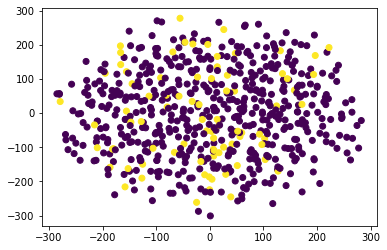

In [11]:
plt.scatter(tsne_features[:,0],tsne_features[:,1],c=labels)

Part 3: Perform a Cluster Analysis with K-means

In [12]:
# Use a for loop to determine the inertia for each k between 1 through 10.
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(myopia_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,7948.905345
1,2,6794.415695
2,3,6031.097742
3,4,5662.587617
4,5,5376.410589


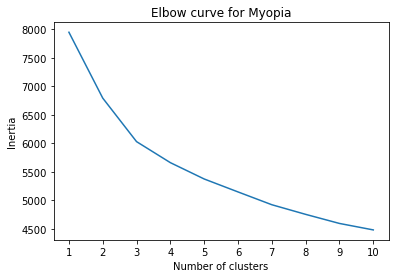

In [13]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for Myopia')
plt.show()

In [14]:
# Create a DataFrame from the PCA transformed data for K-Means modelling and plotting
columns=[]
for i in range(len(pca.components_)):
    columns.append(i+1)
pca_df = pd.DataFrame(myopia_pca, columns=columns)
pca_df['class']= km.labels_
pca_df.head()


,1,2,3,4,5,6,7,8,9,10,class
0,0.535503,1.145004,-1.385019,0.116006,-3.226691,-1.928459,-1.958892,-1.922997,0.026753,0.178144,6
1,-0.624706,-1.575786,-0.794253,1.156287,0.292256,0.349060,-0.455206,0.285332,0.689683,-0.557031,2
2,-0.933479,-0.717076,0.820150,-1.547638,0.173941,0.272783,0.025821,-0.030817,-0.431499,0.013336,8
3,0.106354,1.192475,-0.024441,1.507469,-2.356836,-0.023139,0.236418,-1.717109,-1.230785,-0.703400,6
4,-0.388503,-2.839655,-0.229767,-0.622510,0.271458,-0.928956,0.537900,-1.301787,0.279007,0.631183,2


/Users/tientran/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/tientran/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


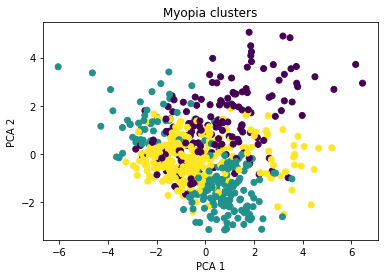

In [15]:
# Initialize the K-Means model with n_clusters 3
model = KMeans(n_clusters=3, random_state=0)

# Train the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add predicted clusters (labels) to DataFrame
pca_df['class'] = model.labels_
# Plot the Clusters
plt.scatter(x=pca_df[1], y=pca_df[2], c=pca_df['class'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Myopia clusters')
plt.show()

PART 4: Make the Recommendation

I believe the number of clusters is 3. t-SNE is not helpful to find some clusters, there are some differencs after adjusting perplexity due to random noise. After performing the K-means some patterns are clustering but the dataset is too small to make a accurate prediction. My recommendation is to get a bigger and organized dataset and to split the data into test and training to test the models above and to able to make more accurate predictions and clustering. 